In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load #to save ur model
from sklearn.model_selection import GridSearchCV

In [3]:
df_Acc=pd.read_csv('Road Safety Data - Accidents 2019.csv')
df_Veh=pd.read_csv('Road Safety Data- Vehicles 2019.csv')
df_Acc.head(5)

C:\Anaconda\envs\gsa2019\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Anaconda\envs\gsa2019\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,18/02/2019,...,0,5,1,1,1,0,0,1,3,E01004762
1,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,15/01/2019,...,-1,-1,4,1,1,0,0,1,3,E01003117
2,2019010155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,01/01/2019,...,0,0,4,1,1,0,0,1,1,E01000943
3,2019010155192,525531.0,184605.0,-0.191044,51.546387,1,2,1,1,01/01/2019,...,0,0,4,1,1,0,0,1,1,E01000973
4,2019010155194,524920.0,184004.0,-0.200064,51.541121,1,3,2,2,01/01/2019,...,0,0,4,1,1,0,0,1,1,E01000546


In [4]:
#Cleaning up the null valued rows
df_Acc_clnd=df_Acc[~df_Acc.isnull().any(axis=1)]
df_Veh_clnd=df_Veh[~df_Veh.isnull().any(axis=1)]

In [5]:
#Transforming 'Time' Attribute from hh:mm to only minutes
a= np.array([(int(str(x).split(':')[0])*60+int(str(x).split(':')[1])) for x in df_Acc_clnd['Time'].values])
df_Acc_clnd['Time_Conv']=a

C:\Anaconda\envs\gsa2019\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
#Visualizing the shape 
print('df_Acc.shape---'+str(df_Acc.shape))
print('df_Veh.shape---'+str(df_Veh.shape))
print('df_Acc_clnd.shape---'+str(df_Acc_clnd.shape))
print('df_Veh_clnd.shape---'+str(df_Veh_clnd.shape))
print('----------------------------------------------------------------------')
print('df_Acc_clnd unique values---')
print('----------------------------------------------------------------------')
print(df_Acc_clnd.nunique(axis=0))
print('----------------------------------------------------------------------')
print('df_Veh_clnd unique values---')
print('----------------------------------------------------------------------')
print(df_Veh_clnd.nunique(axis=0))

df_Acc.shape---(117536, 32)
df_Veh.shape---(216381, 23)
df_Acc_clnd.shape---(111760, 33)
df_Veh_clnd.shape---(216381, 23)
----------------------------------------------------------------------
df_Acc_clnd unique values---
----------------------------------------------------------------------
Accident_Index                                 111760
Location_Easting_OSGR                           88239
Location_Northing_OSGR                          88437
Longitude                                      109327
Latitude                                       107874
Police_Force                                       43
Accident_Severity                                   3
Number_of_Vehicles                                 16
Number_of_Casualties                               18
Date                                              365
Day_of_Week                                         7
Time                                             1439
Local_Authority_(District)                        348
Local

In [8]:
print('-----------------------------------------')
print('Columns same in Accident and Vehicle:')
print('-----------------------------------------')
for c1 in df_Acc_clnd.columns:
    for c2 in df_Veh_clnd.columns:
        if(c1==c2):
            print(c1)

-----------------------------------------
Columns same in Accident and Vehicle:
-----------------------------------------
Accident_Index


In [9]:
df_All_clnd=pd.merge(df_Acc_clnd,df_Veh_clnd,how='inner',on=['Accident_Index'])

In [10]:
df=df_All_clnd.reset_index(drop=True)

##Drop the columns which are irrelevant to get before the accident or totally irrelevant w.r.t the prediction model
df.drop(['Date','Time','Accident_Index','Number_of_Casualties','Vehicle_Reference'
         ,'Police_Force','Did_Police_Officer_Attend_Scene_of_Accident','1st_Point_of_Impact'
         ,'Skidding_and_Overturning','Vehicle_Leaving_Carriageway','Hit_Object_off_Carriageway'
         ,'Driver_Home_Area_Type','Carriageway_Hazards','Towing_and_Articulation','Vehicle_Location-Restricted_Lane'
        ,'Hit_Object_in_Carriageway'],axis=1,inplace=True)

target_c=['Accident_Severity']
df_train=df.drop(target_c,axis=1)
df_target=df[target_c]

Text(0, 0.5, 'No. Of Records')

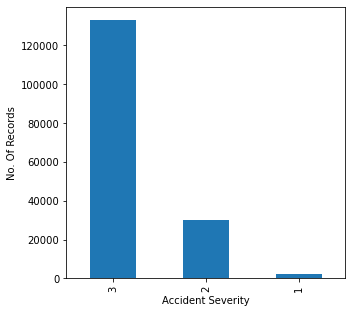

In [11]:
#Determining Balance of our Data Samples
acc_sev_counts=pd.value_counts(df_target['Accident_Severity'],sort=True)
plt.figure(figsize=(5,5))
acc_sev_counts.plot(kind='bar')
plt.xlabel('Accident Severity')
plt.ylabel('No. Of Records')

In [12]:
labelEncodeCols=['LSOA_of_Accident_Location','Local_Authority_(Highway)']
#labelEncodeCols=['Local_Authority_(Highway)']
Local_Authority_Highway               = LabelEncoder()
LSOA_of_Accident_Location               = LabelEncoder()

Local_Authority_Highway.fit(df_train['Local_Authority_(Highway)'])
LSOA_of_Accident_Location.fit(df_train['LSOA_of_Accident_Location'])

df_train['Local_Authority_(Highway)_E']=Local_Authority_Highway.transform(df_train['Local_Authority_(Highway)'])
df_train['LSOA_of_Accident_Location_E']=LSOA_of_Accident_Location.transform(df_train['LSOA_of_Accident_Location'])
df_train.drop(labelEncodeCols,axis=1,inplace=True)

In [13]:

#Performing Over Sampling
#There are various sampling technique you can use like;- NearMiss, SMOTETomek, RandomOverSampler
## RandomOverSampler to handle imbalanced data

os =  RandomOverSampler(random_state=42)
df_train_smpl, df_target_smpl = os.fit_sample(df_train, df_target)

Text(0, 0.5, 'No. Of Records')

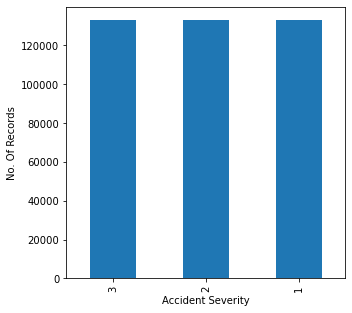

In [14]:
#Checking the new sampled Data set for balance
acc_sev_counts=pd.value_counts(df_target_smpl['Accident_Severity'],sort=True)
plt.figure(figsize=(5,5))
acc_sev_counts.plot(kind='bar')
plt.xlabel('Accident Severity')
plt.ylabel('No. Of Records')

In [15]:
x1_train, x1_test, y1_train, y1_test = train_test_split(df_train_smpl,df_target_smpl.to_numpy(),test_size=0.7,random_state=42)
y1_train=y1_train.reshape(len(y1_train),)
y1_test=y1_test.reshape(len(y1_test),)

In [16]:
model_W_Le = RandomForestClassifier(n_estimators=50)
model_W_Le.fit(x1_train, y1_train)
print("{}".format(model_W_Le.score(x1_test, y1_test)))
metrics.confusion_matrix(y1_test, model_W_Le.predict(x1_test), labels=[3, 2, 1])

0.895365833610304


array([[76803, 16178,   153],
       [12852, 80515,    95],
       [    0,     0, 93217]], dtype=int64)

In [17]:
importances = list(model_W_Le.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x1_train.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Feature--------{}: Importance: {}'.format(*pair)) for pair in feature_importances];

Feature--------Time_Conv: Importance: 0.06
Feature--------LSOA_of_Accident_Location_E: Importance: 0.06
Feature--------Location_Easting_OSGR: Importance: 0.05
Feature--------Location_Northing_OSGR: Importance: 0.05
Feature--------Longitude: Importance: 0.05
Feature--------Latitude: Importance: 0.05
Feature--------Local_Authority_(District): Importance: 0.04
Feature--------1st_Road_Number: Importance: 0.04
Feature--------Speed_limit: Importance: 0.04
Feature--------Age_of_Driver: Importance: 0.04
Feature--------Engine_Capacity_(CC): Importance: 0.04
Feature--------Local_Authority_(Highway)_E: Importance: 0.04
Feature--------Number_of_Vehicles: Importance: 0.03
Feature--------Day_of_Week: Importance: 0.03
Feature--------Vehicle_Manoeuvre: Importance: 0.03
Feature--------Age_of_Vehicle: Importance: 0.03
Feature--------1st_Road_Class: Importance: 0.02
Feature--------Junction_Detail: Importance: 0.02
Feature--------Urban_or_Rural_Area: Importance: 0.02
Feature--------Vehicle_Type: Importanc

In [18]:
from sklearn.tree import export_graphviz
import pydot

tree = model_W_Le.estimators_[5]
export_graphviz(tree, out_file = 'tree.dot', feature_names = x1_train.columns, rounded = True, precision = 1)

In [19]:
(graph, ) = pydot.graph_from_dot_file('tree.dot')

KeyboardInterrupt: 

In [20]:
graph.write_png('tree.jpg')

NameError: name 'graph' is not defined

In [21]:
most_imp_ftr_cols=np.array(feature_importances)[np.array(feature_importances)[:,1].astype(float)>=0.02][:,0]
most_imp_ftr_cols

array(['Time_Conv', 'LSOA_of_Accident_Location_E',
       'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude',
       'Latitude', 'Local_Authority_(District)', '1st_Road_Number',
       'Speed_limit', 'Age_of_Driver', 'Engine_Capacity_(CC)',
       'Local_Authority_(Highway)_E', 'Number_of_Vehicles', 'Day_of_Week',
       'Vehicle_Manoeuvre', 'Age_of_Vehicle', '1st_Road_Class',
       'Junction_Detail', 'Urban_or_Rural_Area', 'Vehicle_Type',
       'Age_Band_of_Driver', 'Driver_IMD_Decile', 'Vehicle_IMD_Decile'],
      dtype='<U39')

In [22]:
x2_train=x1_train[most_imp_ftr_cols]
x2_test=x1_test[most_imp_ftr_cols]
y2_train=y1_train
y2_test=y1_test

In [23]:
model_W_Le.fit(x2_train, y2_train)
print("{}".format(model_W_Le.score(x2_test, y2_test)))
metrics.confusion_matrix(y2_test, model_W_Le.predict(x2_test), labels=[3, 2, 1])

0.8926890458985108


array([[75978, 16974,   182],
       [12778, 80591,    93],
       [    0,     0, 93217]], dtype=int64)

In [24]:
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 100, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [20, 28, 37, 46, 55, 64, 73, 82, 91, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [28]:
model_W_Le_Hp = RandomForestClassifier()
model_W_Le_Hp_Rnd = RandomizedSearchCV(estimator = model_W_Le_Hp, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
model_W_Le_Hp_Rnd.fit(x2_train, y2_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 13.2min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 28, 37, 46, 55, 64,
                                                         73, 82, 91, 100]},
                   random_state=42, verbose=2)

In [29]:
dump(model_W_Le_Hp_Rnd, 'RF_model_W_Le_Hp_Rnd.joblib') 


['RF_model_W_Le_Hp_Rnd.joblib']

In [30]:
model_W_Le_Hp_Rnd.best_params_

{'n_estimators': 73,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

In [31]:
metrics.accuracy_score(y2_test, model_W_Le_Hp_Rnd.best_estimator_.predict(x2_test))

0.9089642010914433

In [32]:
metrics.confusion_matrix(y2_test, model_W_Le_Hp_Rnd.best_estimator_.predict(x2_test), labels=[3, 2, 1])

array([[82607, 10447,    80],
       [14898, 78516,    48],
       [    0,     0, 93217]], dtype=int64)

In [33]:
param_grid_2 = {
    'bootstrap': [False],
    'max_depth': [30, 40, 50],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [63, 73, 83]
}
model_W_Le_Hp_Grd = GridSearchCV(estimator = model_W_Le_Hp, param_grid = param_grid_2, 
                          cv = 3, n_jobs = -1, verbose = 2)
model_W_Le_Hp_Grd.fit(x2_train, y2_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 31.9min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [30, 40, 50],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [63, 73, 83]},
             verbose=2)

In [34]:
dump(model_W_Le_Hp_Grd, 'RF_model_W_Le_Hp_Grd.joblib') 

['RF_model_W_Le_Hp_Grd.joblib']

In [35]:
model_W_Le_Hp_Grd.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 83}

In [36]:
best_Mdl_W_Le_Hp_Grd=model_W_Le_Hp_Grd.best_estimator_
best_Mdl_W_Le_Hp_Grd.score(x2_test, y2_test)

0.9088891509686826